In [1]:
# Import TensorFlow v2.
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create time series dataset of length 128 with 3 classes
# training dataset
idx=np.arange(0,128)
train_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(5000,1,128)
train_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(5000,1,128)
train_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(5000,1,128)
x_train=np.concatenate([train_data_class1,train_data_class2,train_data_class3],0)

# test dataset
test_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(1000,1,128)
test_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(1000,1,128)
test_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(1000,1,128)
x_test=np.concatenate([test_data_class1,test_data_class2,test_data_class3],0)

# create labels for training and test data
y_train=np.concatenate([np.zeros(5000),np.ones(5000),np.ones(5000)*2],0)
y_test=np.concatenate([np.zeros(1000),np.ones(1000),np.ones(1000)*2],0)

y_train.astype(int)
y_test.astype(int)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

y_train=tf.cast(y_train,tf.uint8)
y_test=tf.cast(y_test,tf.uint8)

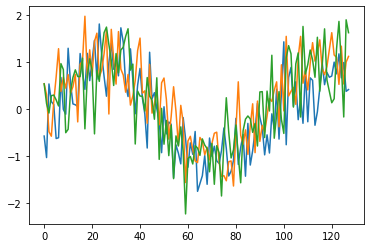

In [3]:
# plot time series data
# class 1
plt.plot(x_train[1,0])
# class 1
plt.plot(x_train[5000+1,0])
# class 1
plt.plot(x_train[10000+1,0])

In [6]:
# time series dataset parameters.
num_classes = 3 # total classes 3
num_features =128  # data features 128

# Training Parameters
learning_rate = 0.001
training_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
num_input = 1 # number of sequences.
timesteps = 128 # timesteps.
num_units = 32 # number of neurons for the LSTM layer.

In [7]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [8]:

# Create LSTM Model.
class BiRNN(Model):
    # Set layers.
    def __init__(self):
        super(BiRNN, self).__init__()
        # Define 2 LSTM layers for forward and backward sequences.
        lstm_fw = layers.LSTM(units=num_units)
        lstm_bw = layers.LSTM(units=num_units, go_backwards=True)
        # BiRNN layer.
        self.bi_lstm = layers.Bidirectional(lstm_fw, backward_layer=lstm_bw)
        # Output layer (num_classes).
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.bi_lstm(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build LSTM model.
birnn_net = BiRNN()

In [9]:

# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [10]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = birnn_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = birnn_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [11]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = birnn_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.392857, accuracy: 0.851562
step: 200, loss: 0.186053, accuracy: 0.960938
step: 300, loss: 0.133629, accuracy: 0.953125
step: 400, loss: 0.142467, accuracy: 0.945312
step: 500, loss: 0.074768, accuracy: 0.976562
step: 600, loss: 0.090061, accuracy: 0.960938
step: 700, loss: 0.056509, accuracy: 0.976562
step: 800, loss: 0.050191, accuracy: 0.984375
step: 900, loss: 0.090197, accuracy: 0.960938
step: 1000, loss: 0.144829, accuracy: 0.937500


In [12]:
# Test model on validation set.
pred = birnn_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.946667
